# SOADML - Incremental methods with second order information

    Authors : Léa Bresson, Charles Dognin
   
The aim of this notebook is to implement and compare the algorithms introduced in 2018 by Gower et al. in the paper ["*Tracking the gradients using the Hessian : A new look at variance reducing stochastic methods*"](http://proceedings.mlr.press/v84/gower18a/gower18a.pdf). We discuss the efficiency of the algorithms proposed in this paper by benchmarking it against SVRG on classification and regression problems. 

The following methods are compared : 
- the original Stochastic Variance Reduced Gradient (*SVRG*) algorithm,
- *SVRG2*, which tracks the gradients using the full Hessian,
- *DIAG*, which tracks the gradients using the robust secant equation,
- *CM*, which tracks the gradients using the low-rank curvature matching approximation of the Hessian,
- *AM*, which uses the low-rank action matching approximation of the Hessian. 

First, we consider a **logistic regression** with ridge penalization using the same dataset as the authors, i.e. the *Gisette* dataset. Then, we consider a **least-squares regression** with ridge penalization (not implemented by Gower et al.) using the *Cadata* dataset from LIBSVM.

### Table of content
[1. Loss function, gradient and Hessian for logistic regression (Gisette dataset)](#dataclassif)<br>
[2. Loss function, gradient and Hessian least-squares regression (Cadata dataset)](#datareg)<br>
[3. Algorithms](#algo)<br>
[4. Parameter values](#para)<br>
[5. Classification task : results and comparisons](#comp1)<br>
[6. Regression task : results and comparisons](#comp2)<br>
[7. Conclusions](#conc)<br>


In [1]:
%matplotlib inline

In [2]:
# Package Imports 

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy.linalg import norm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_svmlight_file, load_diabetes
from scipy.linalg import svd
from scipy.optimize import fmin_l_bfgs_b
import autograd.numpy as np
from autograd import grad as grd
import scipy
import time

In [3]:
np.random.seed(0)

<a id='dataclassif'></a>
# 1. Loss function, gradient and Hessian for logistic regression (Gisette dataset)

## Gisette Dataset Pre-Processing

Gisette is a handwritten digit recognition problem inspired by the MINST dataset. The problem is to separate the highly confusable digits '4' and '9'. This is a binary classification problem. The dataset contains 5000 features and 6000 samples. 

The algorithms implemented in Section 2 are slow with so many features. We decided to use a PCA in order to reduce the size of the feature vector to 300.

In [17]:
def preprocessing_y(filename):
    data = []
    with open(filename) as file:
        for row in file.readlines():
            data.append((row.strip()).split(" "))
    data = np.array(data).astype(int)
    data = np.squeeze(data, axis=1)
    return data

def preprocessing_x(filename):
    data = []
    with open(filename) as file:
        for row in file.readlines():
            data.append((row.strip()).split(" "))
    data = np.array(data).astype(int)
    return data

# Here the shape of x_train is (6000, 5000) = (number of examples, dimension)
x_train_c = preprocessing_x("gisette_train.data")
x_train_c = x_train_c
y_train_c = preprocessing_y("gisette_train.labels")
y_train_c = y_train_c


# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
x_train_c = scaler.fit_transform(x_train_c)
pca = PCA(n_components=50)
x_train_c = pca.fit_transform(x_train_c)

KeyboardInterrupt: 

In [5]:
x_train_c.shape

(6000, 50)

## Logistic loss with a squared-$ \ell$2 regularizer

We want to minimize
$$
\frac 1n \sum_{i=1}^n \log(1 + \exp(-y_i X_i^\top \theta)) + \frac \lambda 2 \|\theta\|_2^2  = \frac 1n \sum_{i=1}^n f_i(\theta)
$$

where
$$
f_i(\theta) = \log(1 + \exp(-y_i X_i^\top \theta) + \frac \lambda 2 \|\theta\|_2^2.
$$

The gradient is 
$$
\nabla f_i(\theta) = - \frac{y_i}{1 + \exp(y_i X_i^\top \theta)} X_i + \lambda \theta.
$$


The Hessian is 
 $$
 H_i(\theta) = - \frac {y_i X_i^\top \exp(-y_i  X_i^\top \theta)  X_i y_i^\top } {\big(1 + \exp(y_i X_i^\top \theta)\big)^2} + \lambda I .
 $$

In [18]:
# We define the functions used in the optimization part 

class Classification(object):
    """A class for the logistic regression with ridge penalization"""
    
    def __init__(self, x_train, y_train, lbda):
        self.x_train = x_train
        self.y_train = y_train
        self.n, self.d = x_train.shape
        self.lbda = lbda
        self.sigma = np.sqrt(0.1)

    def loss(self, theta):
        bAx = self.y_train * np.dot(self.x_train, theta)
        return np.mean(np.log(1. + np.exp(- bAx))) + self.lbda * np.linalg.norm(theta) ** 2 / 2.

    def grad(self, theta):
        bAx = self.y_train * np.dot(self.x_train, theta)
        temp = 1. / (1. + np.exp(bAx))
        grad = - np.dot(self.x_train.T, self.y_train * temp) / self.n + self.lbda * theta
        return grad
    
    def grad_auto(self, theta):
        grad_a = grd(self.loss)
        return grad_a(theta)
    
    def grad_i(self, i, theta):
        grad = - self.x_train[i] * self.y_train[i] / (1. + np.exp(self.y_train[i] * np.dot(self.x_train[i], theta)))
        grad += self.lbda * theta
        return grad
            
    def hess(self, theta):
        D = np.exp(self.y_train * np.dot(self.x_train, theta)) / (1 + np.exp(self.y_train * np.dot(self.x_train, theta))**2)
        D = np.diag(D)
        hess = self.x_train.T.dot(D.dot(self.x_train)) / n + self.lbda
        return hess
    
    def hess_i(self, i, theta):
        temp = np.exp(self.y_train[i] * np.dot(self.x_train[i], theta)) / ((1. + np.exp(self.y_train[i] * np.dot(self.x_train[i], theta))) ** 2)
        xy = self.x_train[i] * self.y_train[i] 
        xy = np.expand_dims(xy, axis=1)
        hess = np.dot(xy, xy.T) * temp + self.lbda
        return hess 
    
    def hess_i_diag(self, i, theta, theta_bar):
        a = (theta - theta_bar) * (self.grad_i(i, theta) - self.grad_i(i, theta_bar)) + (self.sigma ** 2) * np.diag(np.diag(self.hess_i(i, theta_bar)))
        b = (theta - theta_bar) * (theta - theta_bar) + self.sigma ** 2
        return a / b 

## Get a very precise minimum to compute distances to minimum

Gower et al. use the relative suboptimality gap to assess the efficiency of the proposed algorithms: $$\frac{f(\theta)-f(\theta^*)}{f(\theta_0) - f(\theta^*)}$$

To compute the relative suboptimality gap, we assume that $ \theta^*$ is given by the ``scipy.optimize``'s BFGS solver.

In [12]:
n,d = x_train_c.shape
x_init_c = np.zeros(d)
lbda = np.max(np.sum(x_train_c**2, axis=1)) / (4.*n)

model = Classification(x_train_c, y_train_c, lbda)
x_min_c, f_min_c, _ = fmin_l_bfgs_b(model.loss, x_init_c, model.grad, pgtol=1e-30, factr=1e-30)

print("The min of the loss is %.2g" %f_min_c)

The min of the loss is 0.31


<a id='datareg'></a>
# 2. Loss function, gradient and Hessian for least-squares regression (Cadata dataset)


## Cadata Dataset Pre-Processing

The California housing dataset (Cadata) contains details related to the housing of the population in a given California district (number of people in a certain area, geographic area, average income, housing average age, average rooms, etc.). The average house value is the target variable.
The dataset contains 8 features and 20640 samples.

In [6]:
x_train , y_train = load_svmlight_file("cadata.txt")

# Here the shape of x_train is (20640, 8) = (dimension, number of examples)
x_train = x_train.toarray()
y_train = y_train.reshape((y_train.size, 1))
print(x_train.shape)

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
x_train_r = scaler.fit_transform(x_train)
y_train = scaler.fit_transform(y_train)
y_train_r = y_train.reshape((y_train.size,))

(20640, 8)


## Least-squares loss with a squared-$ \ell$2 regularizer

We want to minimize
$$
\frac 1n \sum_{i=1}^n \frac 12 (y_i - X_i^\top \theta)^2 + \frac \lambda 2 \|\theta\|_2^2 = \frac 1n \sum_{i=1}^n f_i(\theta)
$$

where
$$
f_i(\theta) = \frac 12 (y_i - X_i^\top \theta)^2  + \frac \lambda 2 \|\theta\|_2^2.
$$

The gradient is
$$
\nabla f_i(\theta) = (X_i^\top \theta - y_i) X_i + \lambda \theta
$$

The hessian is
$$
H_i(\theta) = X_i {X_i}^{T} + \lambda I
$$


In [21]:
# We define the functions used in the optimization part 

class Regression(object):
    """A class for the least-squares regression with ridge penalization"""

    def __init__(self, x_train, y_train, lbda):
        self.x_train = x_train
        self.y_train = y_train
        self.n, self.d = x_train.shape
        self.lbda = lbda
        self.sigma = np.sqrt(0.1)

    def grad(self, theta):
        return self.x_train.T.dot(self.x_train.dot(theta) - self.y_train) / self.n + self.lbda * theta

    def loss(self, theta):
        return norm(self.x_train.dot(theta) - self.y_train) ** 2 / (2. * self.n) + (self.lbda / 2.) * ((norm(theta)) ** 2)

    def grad_i(self, i, theta):
        a_i = self.x_train[i]
        return (a_i.dot(theta) - self.y_train[i]) * a_i + self.lbda * theta
    
    def hess(self, theta=None): 
        hess = np.dot(self.x_train.T, self.x_train) / self.n + self.lbda
        return hess 
    
    def hess_i(self, i, theta=None):
        a_i = self.x_train[i]
        a_i = np.expand_dims(a_i, axis=1)
        hess = np.dot(a_i, a_i.T) + self.lbda
        return hess
    
    def hess_i_diag(self, i, theta, theta_bar):
        a = (theta - theta_bar) * (self.grad_i(i, theta) - self.grad_i(i, theta_bar)) + (self.sigma ** 2) * np.diag(np.diag(self.hess_i(i, theta_bar)))
        b = (theta - theta_bar) * (theta - theta_bar) + self.sigma ** 2
        return a / b

In [22]:
def optimize_cm(itr1, itr2, x_train, y_train, stepsize, theta_min=[], f_min=[], verbose=True, random=True):
    """"Curvature Matching algorithm.

    Output
    ----------
    theta_bar : np.ndarray, shape=(d,)
                The final theta vector found by the algorithm   
        
    errors: list
            Sequence of errors || theta - theta_min || of the algorithm
            
    relative_objectives: list
            Sequence of relative suboptimality gap [f(theta) - f(theta_min)] / [f(theta_0) - f(theta_min)] of the algorithm
            
    grad_norm: list
             Sequence of gradient norms calculated during the iterations of the algorithm
    
    timing: list
             Sequence of time taken during the iterations of the algorithm
    
    """  
    
    # Initialization
    n,d = x_train.shape
    theta_init = np.zeros(d)
    theta_bar = theta_init.copy()
    
    # History 
    grad_norm = []
    errors = [] 
    relative_objectives = []
    t0 = time.time()
    timing = []
    dt_history = []

    grad_norm.append(np.linalg.norm(model.grad(theta_bar)))
    err = norm(theta_bar - theta_min) #/ norm(theta_min) #
    errors.append(err)
    obj = model.loss(theta_bar) - f_min
    relative = model.loss(theta_init) - f_min    
    relative_objectives.append(obj / relative)
    tim = time.time() - t0
    timing.append(tim)

    # Algorithm  
    for k in range(1, itr1+1):
        
        if random:        
            S = np.random.randn(d, 10)
        else:
            S = generate_S(dt_history, itr2)
            
        grad_k =  model.grad(theta_bar)
        A = np.dot(model.hess(theta_bar), S)
        C = scipy.linalg.pinv(np.dot(S.T, A))
        S_bar = np.dot(S, C)
        A_bar = np.dot(A, C)
        theta = theta_bar.copy()
        
        for t in range(itr2):   
            
            i = np.random.randint(0, n)
            A1 = np.dot(np.dot(np.dot(np.dot(A_bar.dot(S_bar.T), model.hess_i(i, theta_bar)), S_bar), A_bar.T), theta - theta_bar)
            A2 = np.dot(np.dot(A_bar, A_bar.T), theta - theta_bar)
            dt = model.grad_i(i, theta) - model.grad_i(i, theta_bar) + grad_k - A1 + A2
            dt_history.append(dt)
            theta = theta - stepsize * dt
            
        theta_bar = theta
        
        obj = model.loss(theta_bar) - f_min
        robj = obj/relative
        err = norm(theta_bar - theta_min) 
        errors.append(err)
        relative_objectives.append(robj)
        grad_norm.append(np.linalg.norm(model.grad(theta_bar)))
        tim = time.time() - t0
        timing.append(tim)
        
        
        if verbose:
            if k == 1:
                print("Lauching CM solver...")
                print(' | '.join([name.center(10) for name in ["it", "err", "subopt_gap", "time"]]))
            if (k % 10) == 0:
                print(' | '.join([("%d" % k).rjust(10), ("%.2e" % err).rjust(10), ("%.2e" % robj).rjust(10), ("%.4e" % tim).rjust(10)]))
            
            
    return theta_bar, np.array(errors), np.array(relative_objectives), grad_norm, np.array(timing)

In [28]:
n = x_train_r.shape[0]
lbda = np.max(np.sum(x_train_r ** 2, axis=1)) / 3 * n
model = Regression(x_train_r, y_train_r, lbda)
max_squared_sum = np.max(np.sum(x_train_r ** 2, axis=1)) 


print("\033[1m CM on Cadata Dataset: \033[0m")
stepsize = 2 ** 3 / (max_squared_sum + lbda) # Optimal stepsize (a = ???)
cm_theta_r, cm_err_r, cm_robj_r, cm_grad_norm_r, cm_time_r = optimize_cm(100, n, x_train_r, y_train_r, stepsize, x_min_r, f_min_r)

 CM on Cadata Dataset: 


/Users/charlesdognin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in multiply
/Users/charlesdognin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in add
/Users/charlesdognin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in subtract
/Users/charlesdognin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in add


ValueError: array must not contain infs or NaNs

In [37]:
print("\033[1m AM on Cadata Dataset: \033[0m")
stepsize = 2**(1) / (max_squared_sum + lbda) # Optimal stepsize (a = ??)
am_theta_r, am_err_r, am_robj_r, am_grad_norm_r, am_time_r = optimize_am(100, n, x_train_r, y_train_r, stepsize, x_min_r, f_min_r)

 AM on Cadata Dataset: 
Lauching AM solver...
    it     |    err     | subopt_gap |    time   
        10 |   9.62e-01 |   1.00e+00 | 1.3222e+01
        20 |   9.62e-01 |   1.00e+00 | 2.6382e+01
        30 |   9.62e-01 |   1.00e+00 | 3.9508e+01
        40 |   9.62e-01 |   1.00e+00 | 5.2668e+01


KeyboardInterrupt: 

## Get a very precise minimum to compute distances to minimum

To compute the relative suboptimality gap, we assume that $ \theta^*$ is given by the ``scipy.optimize``'s BFGS solver.

In [17]:
n,d = x_train_r.shape
x_init_r = np.zeros(d)
lbda = np.max(np.sum(x_train_r**2, axis=1))  / n

model = Regression(x_train_r, y_train_r, lbda)
x_min_r, f_min_r, _ = fmin_l_bfgs_b(model.loss, x_init_r, model.grad, pgtol=1e-30, factr=1e-30)

print("The min of the loss is %.2g" %f_min_r)

The min of the loss is 0.22


<a id='algo'></a>
# 3. Algorithms



# a) SVRG

In [30]:
def optimize_svrg(itr1, itr2, x_train, y_train, stepsize, theta_min=[], f_min=[], verbose=True):
    """Stochastic variance reduction gradient algorithm.

    Output
    ----------
    theta_bar : np.ndarray, shape=(d,)
                The final theta vector found by the algorithm   
        
    errors: list
            Sequence of errors || theta - theta_min || of the algorithm
            
    relative_objectives: list
            Sequence of relative suboptimality gap [f(theta) - f(theta_min)] / [f(theta_0) - f(theta_min)] of the algorithm
            
    grad_norm: list
             Sequence of gradient norms calculated during the iterations of the algorithm
    
    timing: list
             Sequence of time taken during the iterations of the algorithm
    
    """  
    
    # Initialization
    n,d = x_train.shape
    theta_init = np.zeros(d)
    theta_bar = theta_init.copy()
    
    # History 
    grad_norm = []
    errors = [] 
    relative_objectives = []
    t0 = time.time()
    timing = []

    grad_norm.append(np.linalg.norm(model.grad(theta_bar)))
    err = norm(theta_bar - theta_min) #/ norm(theta_min) #a voir 
    errors.append(err)
    obj = model.loss(theta_bar) - f_min
    relative = model.loss(theta_init) - f_min    
    relative_objectives.append(obj/relative)
    tim = time.time()-t0
    timing.append(tim)

    
    # Algorithm  
    for k in range(1, itr1+1):
        grad_k =  model.grad(theta_bar)
        theta = theta_bar.copy()
        
        for t in range(itr2): 
            i = np.random.randint(0, n) 
            theta = theta - stepsize * (model.grad_i(i, theta) - model.grad_i(i, theta_bar) + grad_k)  
            
        theta_bar = theta
        
        obj = model.loss(theta_bar) - f_min
        robj = obj/relative
        err = norm(theta_bar - theta_min) 
        errors.append(err)
        relative_objectives.append(robj)
        grad_norm.append(np.linalg.norm(model.grad(theta_bar)))
        tim = time.time()-t0
        timing.append(tim)
        
        if verbose:
            if k == 1:
                print("Lauching SVRG solver...")
                print(' | '.join([name.center(10) for name in ["it", "err", "subopt_gap", "time", "loss"]]))
            if (k % 10) == 0:
                print(' | '.join([("%d" % k).rjust(10), ("%.4e" % err).rjust(10), ("%.4e" % robj).rjust(10), ("%.4e" % tim).rjust(10), ("%.4e" % model.loss(theta_bar)).rjust(10)]))
            
            
    return theta_bar, np.array(errors), np.array(relative_objectives), grad_norm, np.array(timing)

## b) SVRG2

In [31]:
def optimize_svrg_2(itr1, itr2, x_train, y_train, stepsize, theta_min=[], f_min=[], verbose=True):
    """"Stochastic variance reduction gradient algorithm with second-order tracking.

    Output
    ----------
    theta_bar : np.ndarray, shape=(d,)
                The final theta vector found by the algorithm   
        
    errors: list
            Sequence of errors || theta - theta_min || of the algorithm
            
    relative_objectives: list
            Sequence of relative suboptimality gap [f(theta) - f(theta_min)] / [f(theta_0) - f(theta_min)] of the algorithm
            
    grad_norm: list
             Sequence of gradient norms calculated during the iterations of the algorithm
    
    timing: list
             Sequence of time taken during the iterations of the algorithm
    
    """  
    
    # Initialization
    n,d = x_train.shape
    theta_init = np.zeros(d)
    theta_bar = theta_init.copy()
    
    # History 
    grad_norm = []
    errors = [] 
    relative_objectives = []
    t0 = time.time()
    timing = []

    grad_norm.append(np.linalg.norm(model.grad(theta_bar)))
    err = norm(theta_bar - theta_min) #/ norm(theta_min) #
    errors.append(err)
    obj = model.loss(theta_bar) - f_min
    relative = model.loss(theta_init) - f_min    
    relative_objectives.append(obj / relative)
    tim = time.time() - t0
    timing.append(tim)
    
    for k in range(1, itr1+1):
        grad_k =  model.grad(theta_bar)
        hess_k = model.hess(theta_bar)
        theta = theta_bar.copy()
        
        for t in range(itr2):
            i = np.random.randint(0, n)
            
            theta = theta - stepsize * (model.grad_i(i, theta) - model.grad_i(i, theta_bar)
                                        - np.dot(model.hess_i(i, theta_bar), theta - theta_bar)
                                        + grad_k + np.dot(hess_k, theta - theta_bar))
        theta_bar = theta
    
        obj = model.loss(theta_bar) - f_min
        robj = obj/relative
        err = norm(theta_bar - theta_min) 
        errors.append(err)
        relative_objectives.append(robj)
        grad_norm.append(np.linalg.norm(model.grad(theta_bar)))
        tim = time.time() - t0
        timing.append(tim)
        
        if verbose:
            if k == 1:
                print("Lauching SVRG2 solver...")
                print(' | '.join([name.center(10) for name in ["it", "err", "subopt_gap", "time", "loss"]]))
            if (k % 10) == 0:
                print(' | '.join([("%d" % k).rjust(10), ("%.4e" % err).rjust(10), ("%.4e" % robj).rjust(10), ("%.4e" % tim).rjust(10), ("%.4e" % model.loss(theta_bar)).rjust(10)]))
            
            
    return theta_bar, np.array(errors), np.array(relative_objectives), grad_norm, np.array(timing)

## c) Diagonal approximation 

In [32]:
def optimize_diag(itr1, itr2, x_train, y_train, stepsize, theta_min=[], f_min=[], verbose=True):
    """"Stochastic variance reduction gradient algorithm with diagonal approximation.

    Output
    ----------
    theta_bar : np.ndarray, shape=(d,)
                The final theta vector found by the algorithm   
        
    errors: list
            Sequence of errors || theta - theta_min || of the algorithm
            
    relative_objectives: list
            Sequence of relative suboptimality gap [f(theta) - f(theta_min)] / [f(theta_0) - f(theta_min)] of the algorithm
            
    grad_norm: list
             Sequence of gradient norms calculated during the iterations of the algorithm
    
    timing: list
             Sequence of time taken during the iterations of the algorithm
    
    """  
    
    # Initialization
    n,d = x_train.shape
    theta = np.zeros(d)
    theta_bar = theta.copy()
    
    # History 
    grad_norm = []
    errors = [] 
    relative_objectives = []
    t0 = time.time()
    timing = []

    grad_norm.append(np.linalg.norm(model.grad(theta_bar)))
    err = norm(theta_bar - theta_min) 
    errors.append(err)
    obj = model.loss(theta_bar) - f_min
    relative = model.loss(theta) - f_min    
    relative_objectives.append(obj / relative)
    tim = time.time() - t0
    timing.append(tim)

    
    # Algorithm  
    for k in range(1, itr1+1):
        grad_k =  model.grad(theta_bar)
        hess_k = model.hess(theta_bar)
        theta = theta_bar.copy()
        
        for t in range(itr2):
            i = np.random.randint(0, n)
            theta = theta - stepsize * (model.grad_i(i, theta) - model.grad_i(i, theta_bar)
                                        - np.dot(model.hess_i_diag(i, theta, theta_bar), theta - theta_bar)
                                        + grad_k + np.dot(hess_k, theta - theta_bar))
            
        theta_bar = theta
        obj = model.loss(theta_bar) - f_min
        robj = obj/relative
        err = norm(theta_bar - theta_min) 
        errors.append(err)
        relative_objectives.append(robj)
        grad_norm.append(np.linalg.norm(model.grad(theta_bar)))
        tim = time.time() - t0
        timing.append(tim)
        
        
        if verbose:
            if k == 1:
                print("Lauching DIAG solver...")
                print(' | '.join([name.center(10) for name in ["it", "err", "subopt_gap", "time", "loss"]]))
            if (k % 10) == 0:
                print(' | '.join([("%d" % k).rjust(10), ("%.4e" % err).rjust(10), ("%.4e" % robj).rjust(10), ("%.4e" % tim).rjust(10), ("%.4e" % model.loss(theta_bar)).rjust(10)]))
          
        
    return theta_bar, np.array(errors), np.array(relative_objectives), grad_norm, np.array(timing)

## d) Curvature Matching


In [33]:
def generate_S(dt_history, itr2):
    k = 10
    T = itr2
    def average_d_i(dt_history, i):
        s = np.sum([dt_history[j] for j in range((T // k) * i, (T // k) * (i + 1) - 1)], axis=0)
        return (k / T) * s
    S = np.array([average_d_i(dt_history, i) for i in range(k)])
    return S.T

In [34]:
def optimize_cm(itr1, itr2, x_train, y_train, stepsize, theta_min=[], f_min=[], verbose=True, random=True):
    """"Curvature Matching algorithm.

    Output
    ----------
    theta_bar : np.ndarray, shape=(d,)
                The final theta vector found by the algorithm   
        
    errors: list
            Sequence of errors || theta - theta_min || of the algorithm
            
    relative_objectives: list
            Sequence of relative suboptimality gap [f(theta) - f(theta_min)] / [f(theta_0) - f(theta_min)] of the algorithm
            
    grad_norm: list
             Sequence of gradient norms calculated during the iterations of the algorithm
    
    timing: list
             Sequence of time taken during the iterations of the algorithm
    
    """  
    
    # Initialization
    n,d = x_train.shape
    theta_init = np.zeros(d)
    theta_bar = theta_init.copy()
    
    # History 
    grad_norm = []
    errors = [] 
    relative_objectives = []
    t0 = time.time()
    timing = []
    dt_history = []

    grad_norm.append(np.linalg.norm(model.grad(theta_bar)))
    err = norm(theta_bar - theta_min) #/ norm(theta_min) #
    errors.append(err)
    obj = model.loss(theta_bar) - f_min
    relative = model.loss(theta_init) - f_min    
    relative_objectives.append(obj / relative)
    tim = time.time() - t0
    timing.append(tim)

    # Algorithm  
    for k in range(1, itr1+1):
        
        if random:        
            S = np.random.randn(d, 10)
        else:
            S = generate_S(dt_history, itr2)
            
        grad_k =  model.grad(theta_bar)
        A = np.dot(model.hess(theta_bar), S)
        C = scipy.linalg.pinv(np.dot(S.T, A))
        S_bar = np.dot(S, C)
        A_bar = np.dot(A, C)
        theta = theta_bar.copy()
        
        for t in range(itr2):   
            
            i = np.random.randint(0, n)
            A1 = np.dot(np.dot(np.dot(np.dot(A_bar.dot(S_bar.T), model.hess_i(i, theta_bar)), S_bar), A_bar.T), theta - theta_bar)
            A2 = np.dot(np.dot(A_bar, A_bar.T), theta - theta_bar)
            dt = model.grad_i(i, theta) - model.grad_i(i, theta_bar) + grad_k - A1 + A2
            dt_history.append(dt)
            theta = theta - stepsize * dt
            
        theta_bar = theta
        
        obj = model.loss(theta_bar) - f_min
        robj = obj/relative
        err = norm(theta_bar - theta_min) 
        errors.append(err)
        relative_objectives.append(robj)
        grad_norm.append(np.linalg.norm(model.grad(theta_bar)))
        tim = time.time() - t0
        timing.append(tim)
        
        
        if verbose:
            if k == 1:
                print("Lauching CM solver...")
                print(' | '.join([name.center(10) for name in ["it", "err", "subopt_gap", "time"]]))
            if (k % 10) == 0:
                print(' | '.join([("%d" % k).rjust(10), ("%.2e" % err).rjust(10), ("%.2e" % robj).rjust(10), ("%.4e" % tim).rjust(10)]))
            
            
    return theta_bar, np.array(errors), np.array(relative_objectives), grad_norm, np.array(timing)

## e) Action Matching

In [35]:
def generate_S(dt_history, itr2):
    k = 10
    T = itr2
    def average_d_i(dt_history, i):
        s = np.sum([dt_history[j] for j in range((T // k) * i, (T // k) * (i + 1) - 1)], axis=0)
        return (k / T) * s
    S = np.array([average_d_i(dt_history, i) for i in range(k)])
    return S.T

In [36]:
def optimize_am(itr1, itr2, x_train, y_train, stepsize, theta_min=[], f_min=[], verbose=True, random=True):
    """"Action Matching algorithm.

    Output
    ----------
    theta_bar : np.ndarray, shape=(d,)
                The final theta vector found by the algorithm   
        
    errors: list
            Sequence of errors || theta - theta_min || of the algorithm
            
    relative_objectives: list
            Sequence of relative suboptimality gap [f(theta) - f(theta_min)] / [f(theta_0) - f(theta_min)] of the algorithm
            
    grad_norm: list
             Sequence of gradient norms calculated during the iterations of the algorithm
    
    timing: list
             Sequence of time taken during the iterations of the algorithm
    
    """  
    
    # Initialization
    n,d = x_train.shape
    theta_init = np.zeros(d)
    theta_bar = theta_init.copy()
    
    # History 
    grad_norm = []
    errors = [] 
    relative_objectives = []
    t0 = time.time()
    timing = []
    dt_history = []
    S = np.zeros((d, 10))

    grad_norm.append(np.linalg.norm(model.grad(theta_bar)))
    err = norm(theta_bar - theta_min) #/ norm(theta_min) #
    errors.append(err)
    obj = model.loss(theta_bar) - f_min
    relative = model.loss(theta_init) - f_min    
    relative_objectives.append(obj / relative)
    tim = time.time() - t0
    timing.append(tim)

    
    # Algorithm  
    for k in range(1, itr1+1):
        
        if random:        
            S = np.random.randn(d, 10)
        else:
            S = generate_S(dt_history, itr2)
    
        grad_k =  model.grad(theta_bar)
        A = np.dot(model.hess(theta_bar), S)
        C = scipy.linalg.pinv(np.dot(S.T, A))
        S_bar = np.dot(S, C)
        A_bar = np.dot(A, C)
        theta = theta_bar.copy()
        
        for t in range(itr2):   
            
            i = np.random.randint(0, n)
            A1 = np.dot(A_bar.dot(S_bar.T), model.hess_i(i, theta_bar))
            A2 = np.eye(d, d) - np.dot(S_bar, A_bar.T)
            A3 = np.dot(np.dot(model.hess_i(i, theta_bar), S_bar), A_bar.T)  
            A4 = np.dot(A_bar, A_bar.T)
            A5 = theta - theta_bar
            dt = model.grad_i(i, theta) - model.grad_i(i, theta_bar) + grad_k - np.dot(np.dot(A1, A2) + A3, A5) 
            + np.dot(A4, A5)
            dt_history.append(dt)
            theta = theta - stepsize * dt
            
        theta_bar = theta
        
        obj = model.loss(theta_bar) - f_min
        robj = obj/relative
        err = norm(theta_bar - theta_min) 
        errors.append(err)
        relative_objectives.append(robj)
        grad_norm.append(np.linalg.norm(model.grad(theta_bar)))
        tim = time.time() - t0
        timing.append(tim)
        
        
        if verbose:
            if k == 1:
                print("Lauching AM solver...")
                print(' | '.join([name.center(10) for name in ["it", "err", "subopt_gap", "time"]]))
            if (k % 10) == 0:
                print(' | '.join([("%d" % k).rjust(10), ("%.2e" % err).rjust(10), ("%.2e" % robj).rjust(10), ("%.4e" % tim).rjust(10)]))
            
            
    return theta_bar, np.array(errors), np.array(relative_objectives), grad_norm, np.array(timing)

<a id='para'></a>

# 4. Parameter values

## - Number of iterations

According to Johnson and Zhang ("*Accelerating Stochastic Gradient Descent using predictive Variance Reduction*") ``itr2`` must be the same order of $n$. Concerning ``itr1``, we arbitrary set it to 100.


## - Introducing the Lipschitz constant

The stepsize used by Gower et al. is $ \frac{2^a}{\max_{i=1,\ldots,n} L_i}$ where $L_i$ the Lipschitz constant of $f_i$ . The value of $a$ is chosen through a grid search procedure for $a = 10,7...,-7,-9$. 

For **logistic regression**, using $\|\cdot\|_{2}$ for the matrix spectrale norm, we have: $L_i = \frac 14 \| X_i \|_2^2 + \lambda$.

For **least-squares regression**, using $\|\cdot\|_{2}$ for the matrix spectrale norm, we have: $L_i = \| X_i \|_2^2 + \lambda$.



## - Regularization parameter

For **logistic regression**, we use the same regularization parameter as Gower et al.: $ \lambda= max_{i=1,…,n} \frac{||X_i||_2^2}{ 4n}$. 

Regarding **least-squares regression**, the regularization parameter is set to $ \lambda= max_{i=1,…,n} \frac{||X_i||_2^2}{n}$.


## - Grid-Search for the stepsize

Like Gower et al., we perform a Grid-Search to select the best stepsize values.

In [23]:
def grid_search(max_squared_sum, lbda, algo, x_train, y_train, x_min, f_min, n_iter):
    """ 
    This function performs a grid-Search for the stepsize.
    """
    
    #a_list = [-5, -4, -3, -2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    a_list = [-4, -2, 1, 3, 5, 7, 9]
    #colors = ['beige', 'bisque', 'mistyrose', 'gold', 'pink', 'red', 'magenta', 'maroon', 'darkviolet', 'indigo' , 'blue', 'royalblue', 'midnightblue', 'k']
    colors = [ 'mistyrose', 'pink', 'magenta', 'maroon', 'darkviolet', 'royalblue', 'midnightblue']
    hist_obj = []
    plt.figure(figsize=(15, 5))

    for a, color in zip(a_list, colors): 
        stepsize = 2**(a) / (max_squared_sum + lbda) 
        try:     
            _, _, robj_gs ,_, time_gs = algo(n_iter, n, x_train, y_train, stepsize, x_min, f_min, verbose = False)  
            label = 'Value of a : %.2g' % a
            plt.semilogy(robj_gs, color=color, label=label, lw= 2) 
            plt.legend()
            hist_obj.append(robj_gs[n_iter])
            print("done for  a = %.2g" % a )
        except OverflowError:
            print("OverflowError for  a = %.2g" % a )
            hist_obj.append(10000)
        except ValueError:
            print("ValueError for  a = %.2g" % a )
            hist_obj.append(10000)
            
    index_gs = np.argmin(hist_obj, axis = 0)
    print("The suboptimality gap is minimized when a = %.2g" %  a_list[index_gs])
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Suboptimality gap", fontsize=14)    
    plt.title("Relative Suboptimality Gap", fontsize=22)    
    plt.grid()
    plt.show()

### Classification Task

**Note: the following cells takes a long time to run**

In [33]:
# Initialization of the model
n = x_train_c.shape[0]
lbda = np.max(np.sum(x_train_c ** 2, axis=1)) / (4. * n)
model = Classification(x_train_c, y_train_c, lbda)
max_squared_sum = np.max(np.sum(x_train_c ** 2, axis=1)) / 4
n_iter = 100
x_train= x_train_c
y_train = y_train_c
x_min = x_min_c
f_min = f_min_c

print("Grid search for SVRG:")
algo = optimize_svrg 
grid_search(max_squared_sum, lbda, algo, x_train, y_train, x_min, f_min, n_iter)
print("")
print("Grid search for SVRG2:")
algo = optimize_svrg_2
grid_search(max_squared_sum, lbda, algo, x_train, y_train, x_min, f_min, n_iter)
print("")
print("Grid search for DIAG:")
algo = optimize_diag
grid_search(max_squared_sum, lbda, algo, x_train, y_train, x_min, f_min, n_iter)
print("")
print("Grid search for CM:")
algo = optimize_cm
grid_search(max_squared_sum, lbda, algo, x_train, y_train, x_min, f_min, n_iter)
print("")
print("Grid search for AM:")
algo = optimize_am
grid_search(max_squared_sum, lbda, algo, x_train, y_train, x_min, f_min, n_iter)

Grid search for SVRG:


KeyboardInterrupt: 

Grid search for DIAG:
done for  a = -4
done for  a = -2
done for  a = 1


/Users/charlesdognin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp
/Users/charlesdognin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/charlesdognin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp
/Users/charlesdognin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp
/Users/charlesdognin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in square
/Users/charlesdognin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/Users/charlesdognin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in double_scalars
/Users/charlesdognin/anaconda

ValueError for  a = 3
ValueError for  a = 5
ValueError for  a = 7


/Users/charlesdognin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in multiply


ValueError for  a = 9
The suboptimality gap is minimized when a = -2


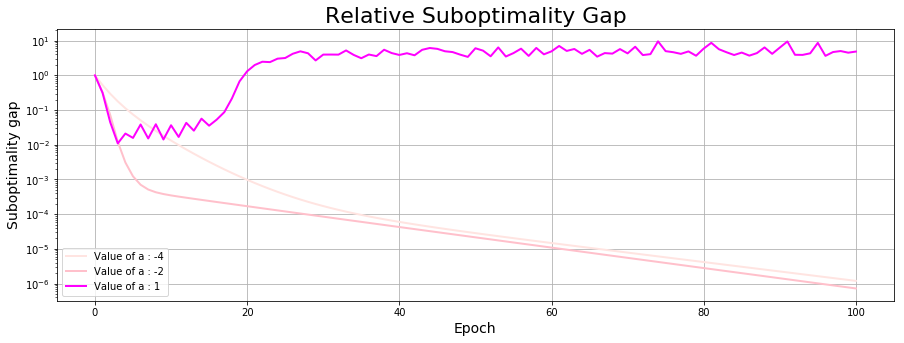


Grid search for CM:
done for  a = -4
done for  a = -2
done for  a = 1
done for  a = 3
done for  a = 5
done for  a = 7
done for  a = 9
The suboptimality gap is minimized when a = -2


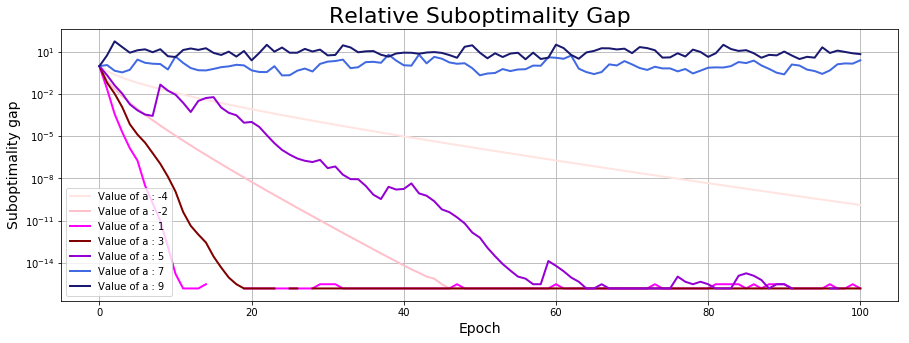


Grid search for AM:
done for  a = -4


KeyboardInterrupt: 

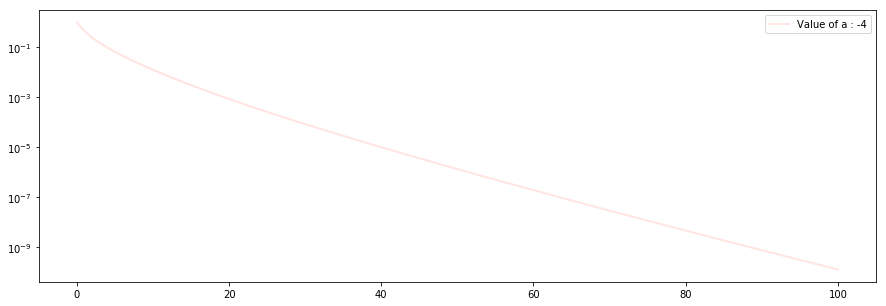

In [34]:
print("Grid search for DIAG:")
algo = optimize_diag
grid_search(max_squared_sum, lbda, algo, x_train, y_train, x_min, f_min, n_iter)
print("")
print("Grid search for CM:")
algo = optimize_cm
grid_search(max_squared_sum, lbda, algo, x_train, y_train, x_min, f_min, n_iter)
print("")
print("Grid search for AM:")
algo = optimize_am
grid_search(max_squared_sum, lbda, algo, x_train, y_train, x_min, f_min, n_iter)

### Regression Task

**Note: the following cells takes a long time to run**

Grid search for SVRG:
done for  a = -4
done for  a = -2
done for  a = 1
done for  a = 3
done for  a = 5
done for  a = 7


/Users/charlesdognin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in multiply
/Users/charlesdognin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in subtract


ValueError for  a = 9
The suboptimality gap is minimized when a = -2


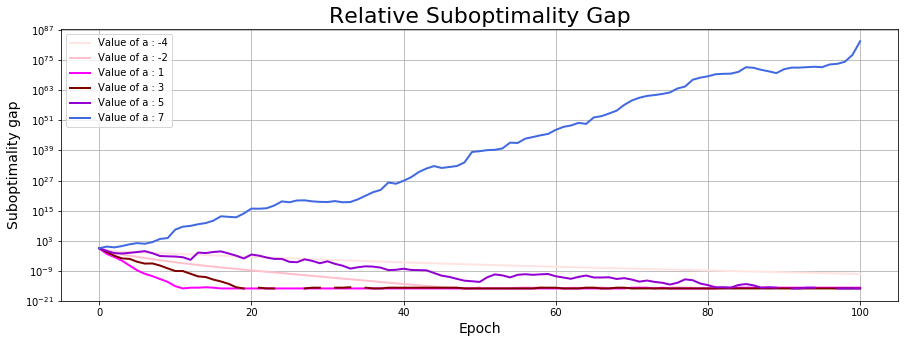


Grid search for SVRG2:


KeyboardInterrupt: 

In [35]:
# Initialization of the model
n = x_train_r.shape[0]
lbda = np.max(np.sum(x_train_r ** 2, axis=1)) / n
model = Regression(x_train_r, y_train_r, lbda)
max_squared_sum = np.max(np.sum(x_train_r ** 2, axis=1)) 
n_iter = 100
x_train= x_train_r
y_train = y_train_r
x_min = x_min_r
f_min = f_min_r

print("Grid search for SVRG:")
algo = optimize_svrg 
grid_search(max_squared_sum, lbda, algo, x_train, y_train, x_min, f_min, n_iter)
print("")
print("Grid search for SVRG2:")
algo = optimize_svrg_2
grid_search(max_squared_sum, lbda, algo, x_train, y_train, x_min, f_min, n_iter)
print("Grid search for Diag:")
algo = optimize_diag
grid_search(max_squared_sum, lbda, algo, x_train, y_train, x_min, f_min, n_iter)
print("")
print("Grid search for CM:")
algo = optimize_cm
grid_search(max_squared_sum, lbda, algo, x_train, y_train, x_min, f_min, n_iter)
print("")
print("Grid search for AM:")
algo = optimize_am
grid_search(max_squared_sum, lbda, algo, x_train, y_train, x_min, f_min, n_iter)

<a id='comp1'></a>
# 5. Classification task: results and comparisons


For each of the following algorithm, we use the optimal stepsize found previously with the grid-search.

In [25]:
# Initialization

n = x_train_c.shape[0]
lbda = np.max(np.sum(x_train_c ** 2, axis=1))  / (4. * n)

model = Classification(x_train_c, y_train_c, lbda)
max_squared_sum = np.max(np.sum(x_train_c ** 2, axis=1)) / 4

print("\033[1m SVRG on Gisette Dataset: \033[0m")
stepsize = 2**1 / (max_squared_sum + lbda) # Optimal stepsize (a = 1)
svrg_theta_c, svrg_err_c, svrg_robj_c, svrg_grad_norm_c, svrg_time_c = optimize_svrg(100, n, x_train_c, y_train_c, stepsize, x_min_c, f_min_c)

 SVRG on Gisette Dataset: 
Lauching SVRG solver...
    it     |    err     | subopt_gap |    time    |    loss   
        10 | 1.1996e-08 | 1.3044e-15 | 1.9881e+00 | 3.1014e-01
        20 | 5.0013e-10 | 1.4493e-16 | 3.9284e+00 | 3.1014e-01
        30 | 5.0013e-10 | 1.4493e-16 | 5.7504e+00 | 3.1014e-01
        40 | 5.0013e-10 | 1.4493e-16 | 7.6384e+00 | 3.1014e-01
        50 | 5.0013e-10 | 1.4493e-16 | 9.5074e+00 | 3.1014e-01
        60 | 5.0013e-10 | 1.4493e-16 | 1.1386e+01 | 3.1014e-01
        70 | 5.0013e-10 | 1.4493e-16 | 1.3257e+01 | 3.1014e-01
        80 | 5.0013e-10 | 1.4493e-16 | 1.5122e+01 | 3.1014e-01
        90 | 5.0013e-10 | 1.4493e-16 | 1.7001e+01 | 3.1014e-01
       100 | 5.0013e-10 | 1.4493e-16 | 1.8862e+01 | 3.1014e-01


In [26]:
print("\033[1m SVRG2 on Gisette Dataset: \033[0m")
stepsize = 2**1 / (max_squared_sum + lbda) # Optimal stepsize (a = 1)
svrg2_theta_c, svrg2_err_c, svrg2_robj_c, svrg2_grad_norm_c, svrg2_time_c = optimize_svrg_2(100, n, x_train_c, y_train_c, stepsize, x_min_c, f_min_c)

 SVRG2 on Gisette Dataset: 
Lauching SVRG2 solver...
    it     |    err     | subopt_gap |    time    |    loss   
        10 | 2.4045e-06 | 8.3110e-11 | 5.1808e+00 | 3.1014e-01
        20 | 5.0456e-10 | 1.4493e-16 | 1.0078e+01 | 3.1014e-01
        30 | 5.0014e-10 | 1.4493e-16 | 1.5108e+01 | 3.1014e-01
        40 | 5.0014e-10 | 1.4493e-16 | 2.0044e+01 | 3.1014e-01
        50 | 5.0014e-10 | 1.4493e-16 | 2.4954e+01 | 3.1014e-01
        60 | 5.0014e-10 | 1.4493e-16 | 2.9883e+01 | 3.1014e-01
        70 | 5.0014e-10 | 1.4493e-16 | 3.4808e+01 | 3.1014e-01
        80 | 5.0014e-10 | 1.4493e-16 | 3.9649e+01 | 3.1014e-01
        90 | 5.0014e-10 | 1.4493e-16 | 4.4540e+01 | 3.1014e-01
       100 | 5.0014e-10 | 1.4493e-16 | 4.9572e+01 | 3.1014e-01


In [32]:
print("\033[1m DIAG on Gisette Dataset : \033[0m")
stepsize = 2**(-4) / (max_squared_sum + lbda) # Optimal stepsize (a = -4)
diag_theta_c, diag_err_c, diag_robj_c, diag_grad_norm_c, diag_time_c = optimize_diag(100, n, x_train_c, y_train_c, stepsize, x_min_c, f_min_c)

 DIAG on Gisette Dataset : 
Lauching DIAG solver...
    it     |    err     | subopt_gap |    time    |    loss   
        10 | 4.6709e-02 | 1.3278e-02 | 8.1510e+00 | 3.1523e-01
        20 | 1.4007e-02 | 9.7881e-04 | 1.6207e+01 | 3.1051e-01
        30 | 6.2210e-03 | 1.7017e-04 | 2.4205e+01 | 3.1020e-01
        40 | 3.7737e-03 | 5.9310e-05 | 3.2839e+01 | 3.1016e-01
        50 | 2.6223e-03 | 2.8123e-05 | 4.1556e+01 | 3.1015e-01
        60 | 1.8947e-03 | 1.4571e-05 | 5.0454e+01 | 3.1015e-01
        70 | 1.3824e-03 | 7.7252e-06 | 5.8891e+01 | 3.1014e-01
        80 | 1.0113e-03 | 4.1236e-06 | 6.7071e+01 | 3.1014e-01
        90 | 7.4037e-04 | 2.2063e-06 | 7.5383e+01 | 3.1014e-01
       100 | 5.4235e-04 | 1.1826e-06 | 8.4095e+01 | 3.1014e-01


In [28]:
print("\033[1m CM on Gisette Dataset : \033[0m")
stepsize = 2**1 / (max_squared_sum + lbda) # Optimal stepsize (a = ???)
cm_theta_c, cm_err_c, cm_robj_c, cm_grad_norm_c, cm_time_c = optimize_cm(100, n, x_train_c, y_train_c, stepsize, x_min_c, f_min_c)

 CM on Gisette Dataset : 
Lauching CM solver...
    it     |    err     | subopt_gap |    time   
        10 |   7.51e-09 |   5.80e-16 | 8.1635e+00
        20 |   5.00e-10 |   1.45e-16 | 1.5965e+01
        30 |   5.00e-10 |   1.45e-16 | 2.3871e+01
        40 |   5.00e-10 |   1.45e-16 | 3.1725e+01
        50 |   5.00e-10 |   1.45e-16 | 3.9620e+01
        60 |   5.00e-10 |   1.45e-16 | 4.7516e+01
        70 |   5.00e-10 |   1.45e-16 | 5.5410e+01
        80 |   5.00e-10 |   1.45e-16 | 6.3547e+01
        90 |   5.00e-10 |   1.45e-16 | 7.1525e+01
       100 |   5.00e-10 |   1.45e-16 | 8.1547e+01


In [31]:
print("\033[1m AM on Gisette Dataset : \033[0m")
stepsize = 2**1 / (max_squared_sum + lbda) # Optimal stepsize (a = ???)
am_theta_c, am_err_c, am_robj_c, am_grad_norm_c, am_time_c = optimize_am(100, n, x_train_c, y_train_c, stepsize, x_min_c, f_min_c)

 AM on Gisette Dataset : 
Lauching AM solver...
    it     |    err     | subopt_gap |    time   
        10 |   9.30e-08 |   9.74e-14 | 1.1772e+01
        20 |   5.00e-10 |   1.45e-16 | 2.3349e+01
        30 |   5.00e-10 |   1.45e-16 | 3.4852e+01
        40 |   5.00e-10 |   1.45e-16 | 4.6327e+01
        50 |   5.00e-10 |   1.45e-16 | 5.7803e+01
        60 |   5.00e-10 |   1.45e-16 | 6.9738e+01
        70 |   5.00e-10 |   1.45e-16 | 8.1307e+01
        80 |   5.00e-10 |   1.45e-16 | 9.3816e+01
        90 |   5.00e-10 |   1.45e-16 | 1.0618e+02
       100 |   5.00e-10 |   1.45e-16 | 1.1974e+02


## Graphical comparisons

In [34]:
# Tool for the plots

def plot_compa(algo_robj, algo_time, algo_err, algo_grad_norm):
    """ 
    This function plots 4 graphs representing (i) the relative suboptimality gap, 
    (ii) the time taken by the algorithm, (iii) the distance to the optimum, (iv) the gradient norm.
    """
    
    plt.figure(figsize=(20, 15))
    algo_names = ["SVRG", "SVRG2", "Diagonal"] 
    algo_nb = len(algo_names)

    plt.subplot(2, 2, 1)

    for i in range(algo_nb):
        plt.semilogy(algo_robj[i], lw=3)
        plt.grid()
        plt.title("Relative Suboptimality Gap", fontsize=22)
        plt.xlabel("Epoch", fontsize=14)
        plt.ylabel("Suboptimality gap", fontsize=14)
        plt.legend(algo_names)

    plt.subplot(2, 2, 2)
    for i in range(algo_nb):
        plt.plot(algo_robj[i], algo_time[i], lw=3)
        plt.yscale('log')
        plt.grid()
        plt.title("Relative Suboptimality Gap", fontsize=22)
        plt.xlabel("Time", fontsize=14)
        plt.ylabel("Suboptimality gap", fontsize=14)
        plt.legend(algo_names)

    plt.subplot(2, 2, 3)
    for i in range(algo_nb):
        plt.semilogy(algo_err[i], lw=3)
        plt.grid()
        plt.title("Distance to optimum", fontsize=22)
        plt.xlabel("Epoch", fontsize=14)
        plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
        plt.legend(algo_names)

    plt.subplot(2, 2, 4)
    for i in range(algo_nb):
        plt.semilogy(algo_grad_norm[i], lw=3)
        plt.grid()
        plt.title("Gradient Norm", fontsize=22)
        plt.xlabel("Epoch", fontsize=14)
        plt.ylabel("Gradient Norm", fontsize=14)
        plt.legend(algo_names);

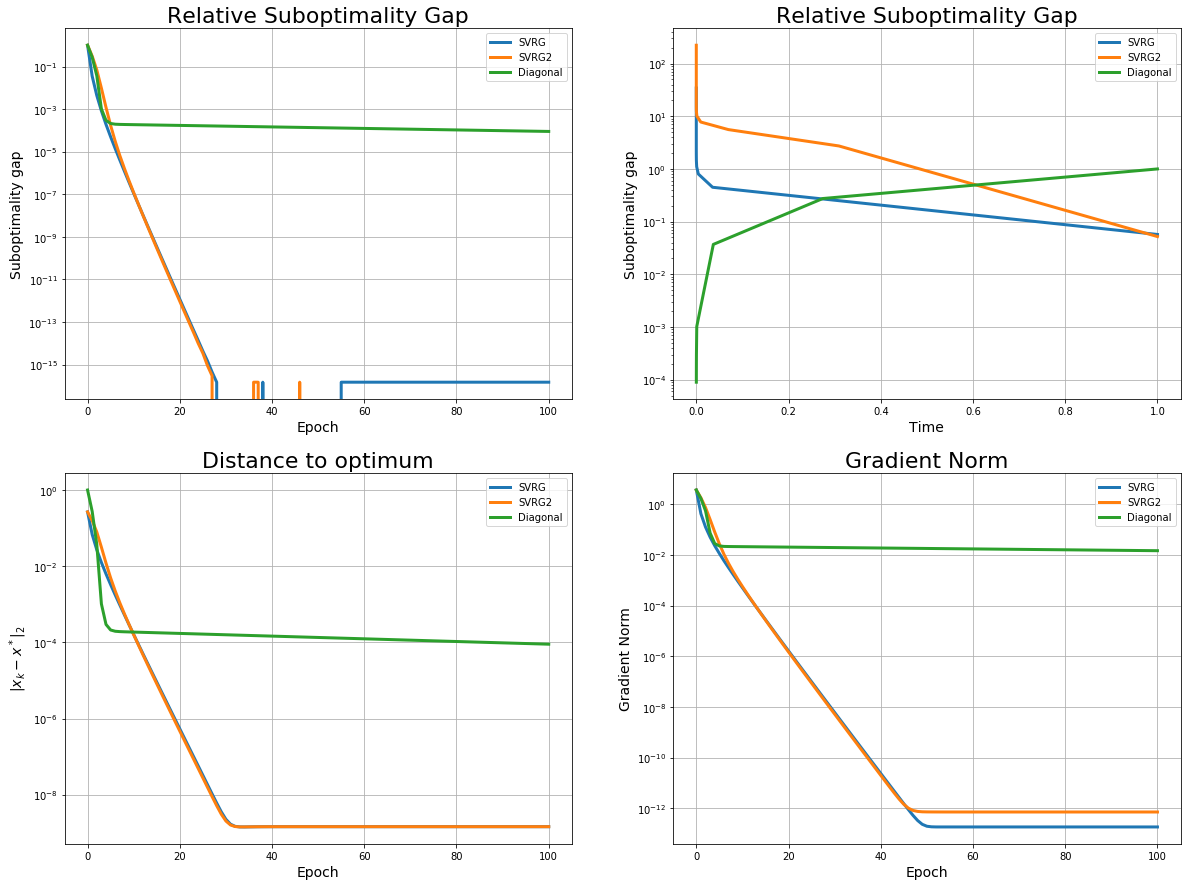

In [35]:
algo_robj_c = [svrg_robj_c, svrg2_robj_c, diag_robj_c]
algo_time_c = [svrg_time_c, svrg2_time_c, diag_robj_c]
algo_err_c = [svrg_err_c, svrg2_err_c, diag_robj_c]
algo_grad_norm_c = [svrg_grad_norm_c, svrg2_grad_norm_c, diag_grad_norm_c]

plot_compa(algo_robj_c, algo_time_c, algo_err_c, algo_grad_norm_c)

## Numerical comparisons

In [42]:
n = x_train_c.shape[0]
lbda = np.max(np.sum(x_train_c ** 2, axis=1))  / (4. * n)
model = Classification(x_train_c, y_train_c, lbda)

print("Min of the Loss %0.8s (L-BGFS) " % f_min_c)
print("Min of the Loss is :  %0.8s (SVRG), %0.8s (SVRG2),%0.8s (DIAG) " % (model.loss(svrg_theta_c), model.loss(svrg2_theta_c),model.loss(diag_theta_c)))
print("The relative suboptimality gap is :  %0.8s (SVRG), %0.8s (SVRG2), %0.8s (DIAG) " % (svrg_robj_c[100], svrg2_robj_c[100], diag_robj_c[100]))
print("Time taken is :  %0.2s (SVRG), %0.2s (SVRG2), %0.2s(DIAG) " % (svrg_time_c[100], svrg2_time_c[100], diag_time_c[100]))

Min of the Loss 0.323007 (L-BGFS) 
Min of the Loss is :  0.323007 (SVRG), 0.323007 (SVRG2),0.323040 (DIAG) 
The relative suboptimality gap is :  1.499736 (SVRG), 0.0 (SVRG2), 8.960599 (DIAG) 
Time taken is :  34 (SVRG), 22 (SVRG2), 75(DIAG) 


<a id='comp2'></a>
# 6. Regression task: results and comparisons

For each of the following algorithm, we use the optimal stepsize found previously with the grid-search.

In [37]:
# Initialization
n = x_train_r.shape[0]
lbda = np.max(np.sum(x_train_r ** 2, axis=1)) / n
model = Regression(x_train_r, y_train_r, lbda)
max_squared_sum = np.max(np.sum(x_train_r ** 2, axis=1)) 

print("\033[1m SVRG on Cadata Dataset: \033[0m")
stepsize = 2**3 / (max_squared_sum + lbda) # Optimal stepsize (a = 3)
svrg_theta_r, svrg_err_r, svrg_robj_r, svrg_grad_norm_r, svrg_time_r = optimize_svrg(100, n, x_train_r, y_train_r, stepsize, x_min_r, f_min_r)

 SVRG on Cadata Dataset: 
Lauching SVRG solver...
    it     |    err     | subopt_gap |    time    |    loss   
        10 | 1.4327e-06 | 8.8865e-12 | 3.2335e+00 | 2.2101e-01
        20 | 5.8954e-09 | 0.0000e+00 | 6.4100e+00 | 2.2101e-01
        30 | 5.8970e-09 | 2.9846e-16 | 9.4166e+00 | 2.2101e-01
        40 | 5.8970e-09 | 9.9486e-17 | 1.2493e+01 | 2.2101e-01
        50 | 5.8970e-09 | 0.0000e+00 | 1.5491e+01 | 2.2101e-01
        60 | 5.8970e-09 | 0.0000e+00 | 1.8508e+01 | 2.2101e-01
        70 | 5.8970e-09 | 0.0000e+00 | 2.1321e+01 | 2.2101e-01
        80 | 5.8970e-09 | 9.9486e-17 | 2.4321e+01 | 2.2101e-01
        90 | 5.8970e-09 | 0.0000e+00 | 2.7385e+01 | 2.2101e-01
       100 | 5.8970e-09 | 0.0000e+00 | 3.0312e+01 | 2.2101e-01


In [38]:
print("\033[1m SVRG2 on Cadata Dataset: \033[0m")
stepsize = 2**1 / (max_squared_sum + lbda) # Optimal stepsize (a = 1)
svrg2_theta_r, svrg2_err_r, svrg2_robj_r, svrg2_grad_norm_r, svrg2_time_r = optimize_svrg_2(100, n, x_train_r, y_train_r, stepsize, x_min_r, f_min_r)

 SVRG2 on Cadata Dataset: 
Lauching SVRG2 solver...
    it     |    err     | subopt_gap |    time    |    loss   
        10 | 5.8963e-09 | 9.9486e-17 | 5.0345e+00 | 2.2101e-01
        20 | 5.8969e-09 | 9.9486e-17 | 1.0285e+01 | 2.2101e-01
        30 | 5.8969e-09 | 9.9486e-17 | 1.5686e+01 | 2.2101e-01
        40 | 5.8969e-09 | 9.9486e-17 | 2.0604e+01 | 2.2101e-01
        50 | 5.8969e-09 | 1.9897e-16 | 2.5341e+01 | 2.2101e-01
        60 | 5.8969e-09 | 1.9897e-16 | 3.0100e+01 | 2.2101e-01
        70 | 5.8969e-09 | 1.9897e-16 | 3.4824e+01 | 2.2101e-01
        80 | 5.8969e-09 | 9.9486e-17 | 3.9637e+01 | 2.2101e-01
        90 | 5.8969e-09 | 9.9486e-17 | 4.4408e+01 | 2.2101e-01
       100 | 5.8969e-09 | 9.9486e-17 | 4.9101e+01 | 2.2101e-01


In [39]:
print("\033[1m DIAG on Cadata Dataset: \033[0m")
stepsize = 2**(-4) / (max_squared_sum + lbda) # Optimal stepsize (a = -4)
diag_theta_r, diag_err_r, diag_robj_r, diag_grad_norm_r, diag_time_r = optimize_diag(100, n, x_train_r, y_train_r, stepsize, x_min_r, f_min_r)

 DIAG on Cadata Dataset: 
Lauching DIAG solver...
    it     |    err     | subopt_gap |    time    |    loss   
        10 | 1.0431e-01 | 2.4229e-03 | 1.0890e+01 | 2.2169e-01
        20 | 1.4502e-02 | 4.2650e-05 | 2.2000e+01 | 2.2102e-01
        30 | 2.2939e-03 | 9.9564e-07 | 3.3587e+01 | 2.2101e-01
        40 | 3.9459e-04 | 2.7358e-08 | 4.4460e+01 | 2.2101e-01
        50 | 7.4643e-05 | 9.0015e-10 | 5.5292e+01 | 2.2101e-01
        60 | 1.5267e-05 | 3.4998e-11 | 6.6062e+01 | 2.2101e-01
        70 | 3.4381e-06 | 1.6860e-12 | 7.6712e+01 | 2.2101e-01
        80 | 7.9451e-07 | 8.8642e-14 | 8.7838e+01 | 2.2101e-01
        90 | 1.8444e-07 | 5.0738e-15 | 9.8613e+01 | 2.2101e-01
       100 | 3.9864e-08 | 2.9846e-16 | 1.0994e+02 | 2.2101e-01


In [47]:
print("\033[1m CM on Cadata Dataset: \033[0m")
stepsize = 2**8 / (max_squared_sum + lbda) # Optimal stepsize (a = ???)
cm_theta_r, cm_err_r, cm_robj_r, cm_grad_norm_r, cm_time_r = optimize_cm(100, n, x_train_r, y_train_r, stepsize, x_min_r, f_min_r)

print("\033[1m AM on Cadata Dataset: \033[0m")
stepsize = 2**(-4) / (max_squared_sum + lbda) # Optimal stepsize (a = ??)
am_theta_r, am_err_r, am_robj_r, am_grad_norm_r, am_time_r = optimize_am(100, n, x_train_r, y_train_r, stepsize, x_min_r, f_min_r)

 CM on Cadata Dataset: 


ValueError: array must not contain infs or NaNs

In [46]:
print("\033[1m AM on Cadata Dataset: \033[0m")
stepsize = 2**(-4) / (max_squared_sum + lbda) # Optimal stepsize (a = ??)
am_theta_r, am_err_r, am_robj_r, am_grad_norm_r, am_time_r = optimize_am(100, n, x_train_r, y_train_r, stepsize, x_min_r, f_min_r)

 AM on Cadata Dataset: 
Lauching AM solver...
    it     |    err     | subopt_gap |    time   
        10 |   2.04e-01 |   9.73e-03 | 9.5840e+00
        20 |   9.29e-02 |   1.52e-03 | 1.9063e+01
        30 |   5.39e-02 |   4.19e-04 | 2.8518e+01


/Users/charlesdognin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in subtract
/Users/charlesdognin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in subtract


ValueError: array must not contain infs or NaNs

## Graphical Comparisons

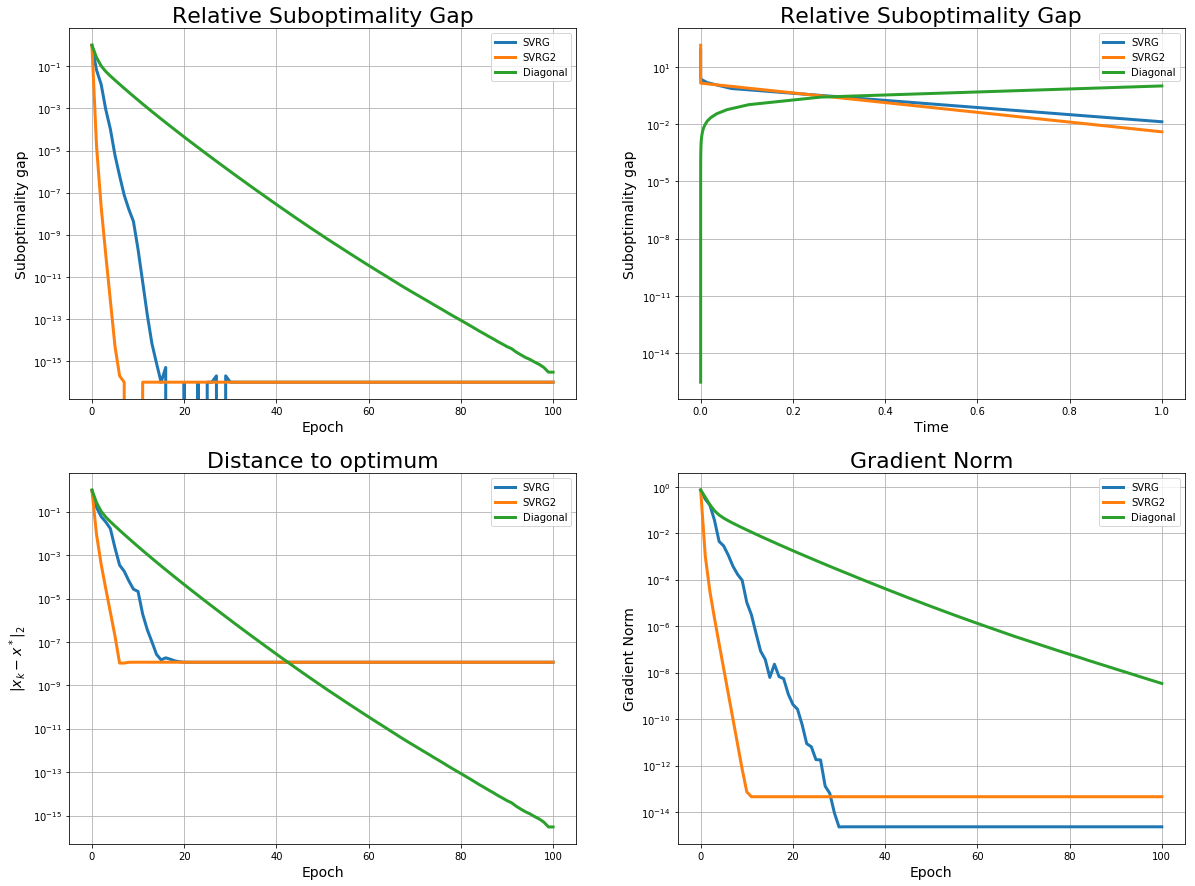

In [40]:
algo_robj_r = [svrg_robj_r, svrg2_robj_r, diag_robj_r]
algo_time_r = [svrg_time_r, svrg2_time_r, diag_robj_r]
algo_err_r = [svrg_err_r, svrg2_err_r, diag_robj_r]
algo_grad_norm_r = [svrg_grad_norm_r, svrg2_grad_norm_r, diag_grad_norm_r]
plot_compa(algo_robj_r, algo_time_r, algo_err_r, algo_grad_norm_r)

## Numerical comparisons

In [41]:
n = x_train_r.shape[0]
lbda = np.max(np.sum(x_train_r ** 2, axis=1)) / n
model = Regression(x_train_r, y_train_r, lbda)

print("Min of the Loss %0.8s (L-BGFS) " % f_min_r)
print("Min of the Loss is :  %0.6s (SVRG), %0.8s (SVRG2),%0.8s (DIAG) " % (model.loss(svrg_theta_r), model.loss(svrg2_theta_r), model.loss(diag_theta_r)))
print("The relative suboptimality gap is :  %0.8s (SVRG), %0.8s (SVRG2), %0.8s (DIAG) " % (svrg_robj_r[100], svrg2_robj_r[100], diag_robj_r[100]))
print("Time taken is :  %0.2s (SVRG), %0.2s (SVRG2), %0.2s(DIAG) " % (svrg_time_r[100], svrg2_time_r[100], diag_time_r[100]))

Min of the Loss 0.221009 (L-BGFS) 
Min of the Loss is :  0.2210 (SVRG), 0.221009 (SVRG2),0.221009 (DIAG) 
The relative suboptimality gap is :  9.948590 (SVRG), 9.948590 (SVRG2), 2.984577 (DIAG) 
Time taken is :  76 (SVRG), 13 (SVRG2), 28(DIAG) 


<a id='conc'></a>

# 7. Conclusion

### Performance comparison 


** Classification **

| Algorithm     | F_min         | Subopt Gap   | Running time |
| ------------- |--------------:| ------------:|-------------:|
| L-bfgs        |   0.323007    |   0          |      -       |
| SVRG          |   0.323007    |   1.499736   |    34        |
| SVRG2         |   0.323007    |   0          |    22        |
| DIAG          |   0.323040    |   8.960599   |    75        |
| CM            | xxxx          |    xxxxx     |    xxxxx     |
| AM            | xxxx          |    xxxxx     |    xxxxx     |




** Regression **


| Algorithm     | F_min         | Subopt Gap   | Running time |
| ------------- |--------------:| ------------:|-------------:|
| L-bfgs        |   0.221009    |      0       |      -       |
| SVRG          |   0.2210      |   9.948590   |    76        |
| SVRG2         |   0.221009    |   9.948590   |    13        |
| DIAG          |   0.221009    |   2.984577   |    28        |
| CM            | xxxx          |    xxxxx     |    xxxxx     |
| AM            | xxxx          |    xxxxx     |    xxxxx     |
